# Modèle de segmentation : Entrainement d'un modèle avec U-NET

## Connexion GPU

In [140]:
import tensorflow as tf
import os

In [141]:
import tensorflow as tf

#This code helps if you are using GPU, else you can comment it.

#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth=True
#sess = tf.compat.v1.Session(config=config)


## Importation des librairies

Installation de librairies manquantes

In [11]:
!pip install h5py==2.10
!pip install segmentation_models
!pip install imshowpair

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


Importation des librairies

In [142]:
import os
import sys
import random
import warnings

import numpy as np
import imageio
import cv2
import matplotlib.pyplot as plt


from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Dense, Dropout, experimental
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from albumentations import Resize,PadIfNeeded

from albumentations import (VerticalFlip, HorizontalFlip, Flip, RandomScale, RandomRotate90, ShiftScaleRotate, CenterCrop, OpticalDistortion,                              
                            ElasticTransform, JpegCompression, HueSaturationValue, GridDistortion,
                            RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CLAHE, ChannelShuffle,
                            InvertImg, RandomGamma, ToGray, PadIfNeeded, RandomCrop, Compose, Transpose, RandomSizedCrop, OneOf, Normalize,PadIfNeeded,Resize)

import tensorflow as tf
import imshowpair
from PIL import Image
from collections import Counter
from focal_loss import BinaryFocalLoss

## Algorithme

### Input

In [198]:
image_sample = os.listdir("./input")

In [199]:
import zipfile
archive = zipfile.ZipFile('./input/raw_data.zip', 'r')

In [200]:
def fabriquer_train(archive):
    dico = {}
    for i in archive.namelist():
        i_temp = i.split("/")
        if i_temp[-1]!='':
            if i_temp[1]=='images':
                imgfile = archive.open(i)
                img = Image.open(imgfile)
                dico[i_temp[-1]]=np.array(img)
    return dico

def fabriquer_test(archive):
    dico = {}
    for i in archive.namelist():
        i_temp = i.split("/")
        if i_temp[-1]!='':
            if i_temp[1]=='masks':
                imgfile = archive.open(i)
                img = Image.open(imgfile)
                dico[i_temp[-1]]=np.array(img)
    return dico

In [201]:
image_ = fabriquer_train(archive)
masks_ = fabriquer_test(archive)
print("Input done")

Input done


In [202]:
image_name = list(image_.keys())
masks_name = list(masks_.keys())

### Echantillon train, test et validation

##### Echantillon train et test

In [203]:
from sklearn.model_selection import train_test_split
X_train, X_test_, Y_train, Y_test_ = train_test_split(image_name, masks_name, test_size=0.2, random_state=42)

train data :
    
    X_train : images

    Y_train : masks

test data :
    
    X_test : images
    
    Y_test : masks

##### Echantillon train et validation

In [204]:
from sklearn.model_selection import train_test_split
x_train_, x_val_, y_train_, y_val_ = train_test_split(X_train, Y_train, test_size=0.2, random_state=42) #text_size=0.3 (à moi, 0.2)

train data :

    X_train : images
        
        x_train : images
        
        x_val : images

    Y_train : masks
        
        y_train : masks
        
        y_val : masks

test data :

    X_test : images

    Y_test : masks

### Recherche des images

In [205]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'data/train_data/'
TEST_PATH = 'data/test_data/'
#TRAIN_PATH = 'data/nuclei_train_data/'
#TEST_PATH = 'data/nuclei_val_data/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [206]:
def get_X_data(ids):
    ids.sort()
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # we'll be using skimage library for reading file
        img = image_[id_][:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X[n] = img
    return X

def get_Y_data(ids):
    ids.sort()
    Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        masque_ = masks_[id_]
        gray_file = rgb2gray(masque_)
        threshold = threshold_otsu(gray_file)
        binary_file = (gray_file > threshold)
        masque_ = np.expand_dims(resize(binary_file, (IMG_HEIGHT, IMG_WIDTH), mode='constant',preserve_range=True), axis=-1)
        Y[n] = masque_
    return Y

In [207]:
print('Getting and resizing train images ... ')

x_train = get_X_data(x_train_)
y_train = get_Y_data(y_train_)

x_val = get_X_data(x_val_)
y_val = get_Y_data(y_val_)

X_test = get_X_data(X_test_)
Y_test = get_Y_data(Y_test_)

Getting and resizing train images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:32<00:00,  1.02s/it]
<ipython-input-206-a83f544650f2>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  0%|                                                                                           | 0/32 [00:00<?, ?it/s]<ipython-input-206-a83f544650f2>:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Dep

In [208]:
dico1 = ['Taile X_train','Taile X_test','Taile Y_train','Taile Y_test']
dico2 = [len(X_train),len(X_test),len(Y_train),len(Y_test)]

dico3 = ['Taile x_train', 'Taile x_val','Taile y_train','Taile y_val']
dico4 = [len(x_train),len(x_val),len(y_train),len(y_val)]

### Algorithme U-NET

In [209]:
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               padding="same")(input_tensor) # padding="valid"
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), 
               padding="same")(x)
    x = Activation("relu")(x)
    return x

In [210]:
def get_unet(input_img, n_filters,kernel_size=3):
    # contracting path # encoder
    c1 = conv2d_block(input_img, n_filters=n_filters*4, kernel_size=3) #The first block of U-net
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv2d_block(p1, n_filters=n_filters*8, kernel_size=3)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv2d_block(p2, n_filters=n_filters*16, kernel_size=3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c10 = conv2d_block(p3, n_filters=n_filters*16, kernel_size=3)
    p10 = MaxPooling2D((2, 2)) (c10)

    c12 = conv2d_block(p10, n_filters=n_filters*16, kernel_size=3)
    p12 = MaxPooling2D((2, 2)) (c12)

    c14 = conv2d_block(p12, n_filters=n_filters*16, kernel_size=3)
    p14 = MaxPooling2D((2, 2)) (c14)

    c4 = conv2d_block(p14, n_filters=n_filters*32, kernel_size=3)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*64, kernel_size=3) # last layer on encoding path 
    
    # expansive path # decoder
    u6 = Conv2DTranspose(n_filters*32, (3, 3), strides=(2, 2), padding='same') (c5) #upsampling included
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, n_filters=n_filters*32, kernel_size=3)

    u15 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (c6)
    u15 = concatenate([u15, c14])
    c15 = conv2d_block(u15, n_filters=n_filters*16, kernel_size=3)

    u13 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (c15)
    u13 = concatenate([u13, c12])
    c13 = conv2d_block(u13, n_filters=n_filters*16, kernel_size=3)

    u11 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (c13)
    u11 = concatenate([u11, c10])
    c11 = conv2d_block(u11, n_filters=n_filters*16, kernel_size=3)

    u7 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (c11)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, n_filters=n_filters*16, kernel_size=3)

    u8 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, n_filters=n_filters*8, kernel_size=3)

    u9 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, n_filters=n_filters*4, kernel_size=3)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

### Métrique Dice

In [211]:
def dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + eps) #eps pour éviter la division par 0 

### Data Augmentation

Nombre d'images transformée pour une image et une transformation.

Exemple : Pour une image *sample.png* et une transformation *rotation*.

On fixe aug_proportion=4

On obtient : 
- *sample.png* original
- *sample.png* rotation 90 degree
- *sample.png* rotation 100 degree
- *sample.png* rotation 10 degree
- *sample.png* rotation 89 degree

In [212]:
aug_proportion = 1 #how much are we increasing the data set example 4 means each image will have 4 correspondents synthetic images

In [213]:
#random rotate
n_aug = int(len(x_train) * aug_proportion)
X_aug = np.zeros((n_aug, IMG_HEIGHT, IMG_WIDTH, 3))
Y_aug = np.zeros((n_aug, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)


aug = Compose([RandomRotate90(p=1), JpegCompression (quality_lower=99, quality_upper=100,  p=0.5)]) #transformations applied 


for i in range(0,int(len(x_train))):
        j=aug_proportion*i
        for z in range(0,aug_proportion):
              step=(z+j)
              augmented = aug(image=np.float32(x_train[i]), mask=y_train[i]*1)
              X_aug[step] = augmented['image']
              Y_aug[step] = augmented['mask']

RGB_image_train_aug = np.append(x_train, X_aug, axis=0)
Mask_train_aug = np.append(y_train, Y_aug, axis=0)

#Blur 
n_aug = int(len(x_train) * aug_proportion)
X_aug = np.zeros((n_aug, IMG_HEIGHT, IMG_WIDTH, 3))
Y_aug = np.zeros((n_aug, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)


aug = Compose([Blur(p=1), JpegCompression (quality_lower=99, quality_upper=100,  p=0.5)]) #transformations applied 


for i in range(0,int(len(x_train))):
        j=aug_proportion*i
        for z in range(0,aug_proportion):
              step=(z+j)
              augmented = aug(image=np.float32(x_train[i]), mask=y_train[i]*1)
              X_aug[step] = augmented['image']
              Y_aug[step] = augmented['mask']

RGB_image_train_aug = np.append(RGB_image_train_aug,X_aug, axis=0)
Mask_train_aug = np.append(Mask_train_aug,Y_aug, axis=0)

#ElasticTransform 
n_aug = int(len(x_train) * aug_proportion)
X_aug = np.zeros((n_aug, IMG_HEIGHT, IMG_WIDTH, 3))
Y_aug = np.zeros((n_aug, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)


aug = Compose([ElasticTransform(p=1), JpegCompression (quality_lower=99, quality_upper=100,  p=0.5)]) #transformations applied 


for i in range(0,int(len(x_train))):
        j=aug_proportion*i
        for z in range(0,aug_proportion):
              step=(z+j)
              augmented = aug(image=np.float32(x_train[i]), mask=y_train[i]*1)
              X_aug[step] = augmented['image']
              Y_aug[step] = augmented['mask']

RGB_image_train_aug = np.append(RGB_image_train_aug,X_aug, axis=0)
Mask_train_aug = np.append(Mask_train_aug,Y_aug, axis=0)

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\albumentations\augmentations\transforms.py:868: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\albumentations\augmentations\functional.py:648: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


In [214]:
dico5 = ['Taile x_train (after data augmentation)', 'Taile x_val','Taile y_train (after data augmentation)','Taile y_val']
dico6 = [len(RGB_image_train_aug),len(x_val),len(Mask_train_aug),len(y_val)]

### Création du modèle

In [215]:
n_filters_user = 3

In [216]:
input_img = Input((256,256, 3), name='img')
model = get_unet(input_img, n_filters=n_filters_user, kernel_size=3) #nombre de filtre

Compilation du modèle

In [217]:
learning_rate_user = 0.0007
gamma_user = 0.6

In [218]:
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_user)
model.compile(optimizer=opt, loss=[BinaryFocalLoss(gamma=gamma_user)], metrics=[dice_coefficient]) #focal loss
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_155 (Conv2D)             (None, 256, 256, 12) 336         img[0][0]                        
__________________________________________________________________________________________________
activation_150 (Activation)     (None, 256, 256, 12) 0           conv2d_155[0][0]                 
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 256, 256, 12) 1308        activation_150[0][0]             
____________________________________________________________________________________________

### Instruction d'arrêt et sauvegarde du meilleur modèle

Insérer le nom du meilleur modèle

In [219]:
name = "best_model"

Fabriquer l'instruction d'arrêt et la sauvegarde du modèle

In [220]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, mode='auto') #Stop training when a monitored metric has stopped improving.

checkpoint_filepath = './output/'+name+'.h5'
Model_check = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto') #Callback to save the Keras model or model weights at some frequency.

### Modélisation

#### Entrainement

In [221]:
batch_size_user = 2

In [222]:
results = model.fit(RGB_image_train_aug,Mask_train_aug, 
                    validation_data=(x_val,y_val),
                    epochs=50, batch_size = batch_size_user,
                    callbacks=[early_stop,Model_check])

Epoch 1/50
64/64 [==============================] - 3s 25ms/step - loss: 0.1641 - dice_coefficient: 0.0483 - val_loss: 0.0536 - val_dice_coefficient: 0.0711

Epoch 00001: val_loss improved from inf to 0.05364, saving model to ./output\best_model.h5
Epoch 2/50
64/64 [==============================] - 1s 20ms/step - loss: 0.0487 - dice_coefficient: 0.0955 - val_loss: 0.0463 - val_dice_coefficient: 0.1317

Epoch 00002: val_loss improved from 0.05364 to 0.04629, saving model to ./output\best_model.h5
Epoch 3/50
64/64 [==============================] - 1s 20ms/step - loss: 0.0450 - dice_coefficient: 0.1189 - val_loss: 0.0435 - val_dice_coefficient: 0.1606

Epoch 00003: val_loss improved from 0.04629 to 0.04353, saving model to ./output\best_model.h5
Epoch 4/50
64/64 [==============================] - 1s 20ms/step - loss: 0.0438 - dice_coefficient: 0.1380 - val_loss: 0.0442 - val_dice_coefficient: 0.1817

Epoch 00004: val_loss did not improve from 0.04353
Epoch 5/50
64/64 [==================

#### Sauvegarde des courbes de validation et d'apprentissage dans le dossier output/train_validation_curve

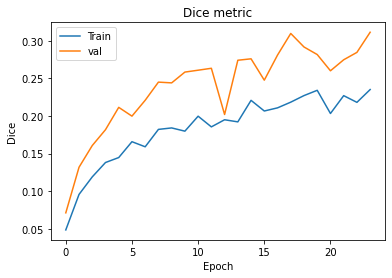

In [223]:
plt.plot(results.history['dice_coefficient'])
plt.plot(results.history['val_dice_coefficient'])
plt.title('Dice metric')
plt.ylabel('Dice')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.savefig('./output/train_validation_curve/Dice_metric.png')

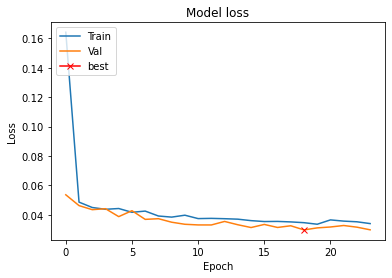

In [224]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val','best'], loc='upper left')
plt.savefig('./output/train_validation_curve/loss.png')

In [225]:
dico7 = ['plus petit coefficient loss de validation']
dico8 = [np.min(results.history["val_loss"])]

#### Test

On récupère le meilleur modèle

In [226]:
model_New = tf.keras.models.load_model('./output/'+name+'.h5',custom_objects={'dice_coefficient': dice_coefficient})
model_New.compile(optimizer=opt, loss=[BinaryFocalLoss(gamma=gamma_user)], metrics=[dice_coefficient]) #focal loss

On test le modèle

In [227]:
eval_test=model_New.evaluate(X_test,Y_test)

1/1 [==============================] - 1s 637ms/step - loss: 0.0347 - dice_coefficient: 0.3623


In [228]:
dico9 = ['Test loss','Test dice']
dico10 = [eval_test[0],eval_test[1]]

### Optimisation du seuil de segmentation

Prédiction des masques par le modèle

In [229]:
Mask_valid_pred_int= model_New.predict(x_val, verbose=2) #predict the masks, the output is a probability map

1/1 - 0s


Optimisation du seuil de segmentation

In [230]:
from sklearn.metrics import f1_score

# compute F1-score for a set of thresholds from (0.1 to 0.9 with a step of 0.1)
prob_thresh = [i*10**-1 for i in range(1,10)]
perf=[] # define an empty array to store the computed F1-score for each threshold
perf_ALL=[]
for r in tqdm(prob_thresh): # all th thrshold values
    preds_bin = ((Mask_valid_pred_int> r) + 0 )
    preds_bin1=preds_bin[:,:,:,0]
    GTALL=y_val[:,:,:,0]
    for ii in range(len(GTALL)): # all validation images
        predmask=preds_bin1[ii,:,:]
        GT=GTALL[ii,:,:]
        l = GT.flatten()
        p= predmask.flatten()
        perf.append(f1_score(l, p)) # re invert the maps: cells: 1, back :0
    perf_ALL.append(np.mean(perf))
    perf=[]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 13.47it/s]


Sauvegarde du seuil d'optimisation

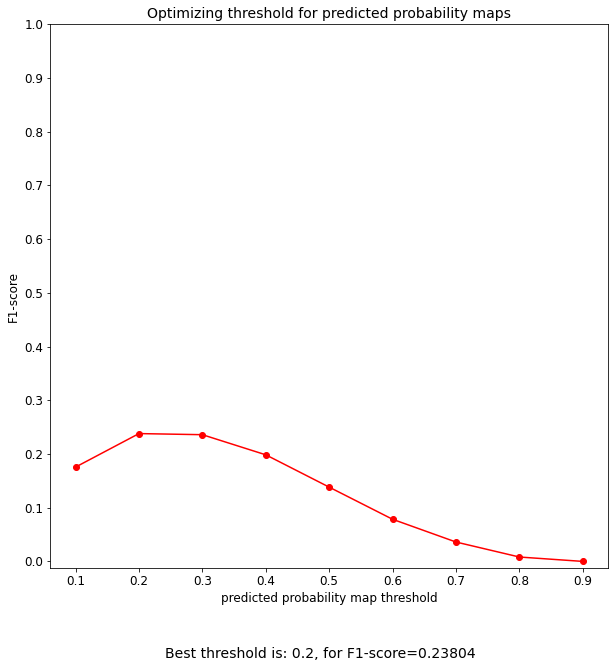

In [231]:
# Plot F1-score function of threshold values and print the best threshold that gives the highest F1-score.
max_f1 = max(perf_ALL)  # Find the maximum y value
op_thr = prob_thresh[np.array(perf_ALL).argmax()]  # Find the x value corresponding to the maximum y value

plt.figure(figsize=(10,10))
plt.plot(prob_thresh, perf_ALL,'ro-')
plt.ylim(top=1) 
plt.xticks(prob_thresh)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.xlabel('predicted probability map threshold',fontsize=12)
plt.ylabel('F1-score', fontsize=12)
plt.title("Optimizing threshold for predicted probability maps",fontsize=14)
figtext_args = (0.5, 0,
                "Best threshold is: "+str(op_thr)+', for F1-score='+str(np.round(max_f1,5)))
  
figtext_kwargs = dict(horizontalalignment ="center", 
                      fontsize = 14, wrap = True)
plt.figtext(*figtext_args, **figtext_kwargs)
None;
plt.savefig('./output/threshold_optimizing/threshold_optimizing_plot.png')

In [232]:
dico11 = ['seuil optimal']
dico12 = [op_thr]

Application du seuil optimisé sur les images prédites par le modèle

In [233]:
preds_test = model_New.predict(X_test, verbose=1)
# we apply a threshold on predicted mask (probability mask) to convert it to a binary mask.
preds_test_opt = (preds_test >op_thr).astype(np.uint8)

1/1 [==============================] - 0s 18ms/step


Sauvegarde des images et masques

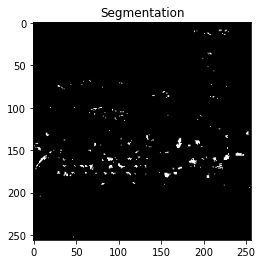

In [234]:
for ix,name in zip(range(0, len(X_test)),X_test_):
  plt.imshow(cv2.cvtColor(X_test[ix,:,:,0], cv2.COLOR_BGR2RGB))
  plt.title("Original")
  plt.savefig('./output/prediction/'+name+'_original.png')
  plt.imshow(np.squeeze(Y_test[ix, :, :, 0]), cmap='gray')
  plt.title("Ground truth")
  plt.savefig('./output/prediction/'+name+'_output.png')
  plt.imshow(np.squeeze(preds_test_opt[ix, :, :, 0]),cmap='gray')
  plt.title("Segmentation")
  plt.savefig('./output/prediction/'+name+'_output_prediction.png')

#### Performance

In [235]:
PIXEL_TEST = []
PIXEL_PRED = []
for ix in range(len(X_test_)):
  a = Y_test[ix, :, :, 0]
  b = preds_test_opt[ix, :, :, 0]
  for i in range(256):
    for j in range(256):
      PIXEL_TEST.append(int(a[i][j]))
      PIXEL_PRED.append(int(b[i][j]))
  
Y_t = K.constant(PIXEL_TEST)
pred_t = K.constant(PIXEL_PRED)
dice = K.get_value(dice_coefficient(Y_t,pred_t))
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(Y_t,pred_t)
jaccard = m.result().numpy()

In [236]:
dico13 = ['Dice','Jaccard']
dico14 = [dice,jaccard]

#### ROC Curve

In [237]:
def plot_roc_curve(fper, tper,PIXEL_TEST, PIXEL_prob):
    from sklearn.metrics import roc_curve,roc_auc_score
    
    auc_score=roc_auc_score(PIXEL_TEST, PIXEL_prob)
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('Taux de faux positif')
    plt.ylabel('Taux de vrai positif')
    plt.title('Receiver Operating Characteristic Curve')
    figtext_args = (0.2, 0.01,
                "*AUC score: "+str(np.round(auc_score,5)))
  
    figtext_kwargs = dict(horizontalalignment ="center", 
                          fontsize = 11, wrap = True)
    plt.figtext(*figtext_args, **figtext_kwargs)
    plt.legend()
    plt.savefig('./output/performance/ROC_Curve.png')

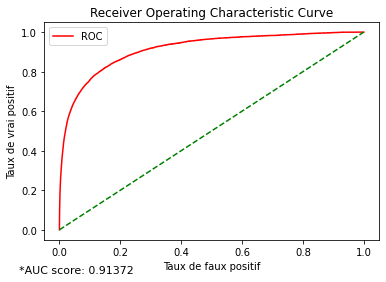

In [238]:
PIXEL_prob = []
for ix in range(len(preds_test)):
  tab_a = preds_test[ix]
  for i in range(256):
    for j in range(256):

      PIXEL_prob.append(tab_a[i][j])

from sklearn.metrics import roc_curve,roc_auc_score

fper, tper, thresholds = roc_curve(PIXEL_TEST, PIXEL_prob)
plot_roc_curve(fper, tper,PIXEL_TEST, PIXEL_prob)
auc_score=roc_auc_score(PIXEL_TEST, PIXEL_prob)
dico15 = ['AUC score']
dico16 = [auc_score]

#### Image de confusion

In [239]:
for ix,name in zip(range(10),X_test_):
  #processing
  GT = np.squeeze(Y_test[ix, :, :, 0])
  predict = np.squeeze(preds_test_opt[ix, :, :, 0])

  GT_new = np.zeros([len(GT),len(GT)],dtype="uint8")
  for i in range(len(GT)):
    for j in range(len(GT)):
      if GT[i][j]: #true
        GT_new[i][j] = 1
      else:
        GT_new[i][j] = 0
    
  IMAGE_OUTPUT = np.zeros((len(GT),len(GT),3),dtype="uint8")
  for i in range(len(predict)):
    for j in range(len(predict)):
      if predict[i][j]==1 and GT_new[i][j]==1: #TP WHITE
        IMAGE_OUTPUT[i,j,0]=255 #r
        IMAGE_OUTPUT[i,j,1]=255 #g
        IMAGE_OUTPUT[i,j,2]=255 #b
      if predict[i][j]==1 and GT_new[i][j]==0: #FP RED
        IMAGE_OUTPUT[i,j,0]=255 #r
        IMAGE_OUTPUT[i,j,1]=0 #g
        IMAGE_OUTPUT[i,j,2]=0 #b
      if predict[i][j]==0 and GT_new[i][j]==1: #FN GREEN
        IMAGE_OUTPUT[i,j,0]=0 #r
        IMAGE_OUTPUT[i,j,1]=255 #g
        IMAGE_OUTPUT[i,j,2]=0 #b
      if predict[i][j]==0 and GT_new[i][j]==0: #TN BLACK
        IMAGE_OUTPUT[i,j,0]=0 #r
        IMAGE_OUTPUT[i,j,1]=0 #g
        IMAGE_OUTPUT[i,j,2]=0 #b
  new_output = resize(IMAGE_OUTPUT, (700, 700), mode='constant', preserve_range=True)
  cv2.imwrite('./output/prediction/'+name+'_confusion.png',new_output)

#### Sauvegarde du tableau

In [240]:
import pandas as pd
dico_col1 = dico1+dico3+dico5+dico7+dico9+dico11+dico13+dico15
dico_col2 = dico2+dico4+dico6+dico8+dico10+dico12+dico14+dico16
output_table = pd.DataFrame({'col 1' : dico_col1, 'col 2' : dico_col2})
output_table.to_csv('./output/table.csv')